In [1]:
import torch
import numpy as np
import random
from torch import nn

We will try our own toy transative closure to test their methods. We will use the Stanford Encyclopedia of Philosophy ontology kept by the Indiana Philosophy Ontology project (https://inpho.cogs.indiana.edu/).

We'll use a subtree that looks like this:

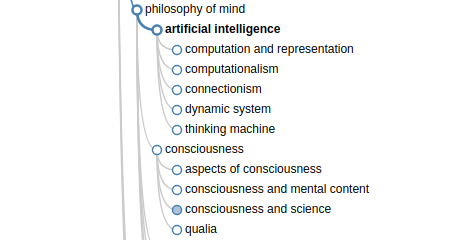

In [2]:
vocab_dict = {
    0: 'philosophy of mind',
    1: 'artificial intelligence',
    2: 'computation and representation',
    3: 'computationalism',
    4: 'connectionism',
    5: 'dynamic system',
    6: 'thinking machine',
    7: 'consciousness',
    8: 'aspects of consciousness',
    9: 'consciousness and mental content',
    10: 'consciousness and science',
    11: 'qualia'}

The transitive closure matrix should then look like this:

In [3]:
trans_closure = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],])

In [11]:
# Global variables
vocab_size = trans_closure.shape[0]
num_neg = 3
embed_dim = 2
stability = 1e-6

# Embeddings
embeddings = nn.Embedding(vocab_size, embed_dim)
embeddings.weight = nn.Parameter(
    torch.FloatTensor(vocab_size, embed_dim)
        .uniform_(-0.001, 0.001),  # Paper recommended initialization
    requires_grad=False)

In [70]:
# Data preparation
def neg_samples(u, v):
    N = [u]  # They add u to this set (eq6) but that doesn't seem to make sense?
             # I guess it adds a one to be summed in the denominator
    pos_ixs = [ix for ix in np.nonzero(trans_closure[u, :])[0].tolist()
               if ix != u]
    neg_ixs = [ix for ix in range(vocab_size)
               if (ix not in pos_ixs and ix != u)]
    num_negs = min(len(neg_ixs), num_neg)
    if num_negs > 0:
        N += random.sample(neg_ixs, num_negs)
    return N

def epoch_data():
    u, v = np.nonzero(trans_closure)
    pos_pairs = [(a, b) for a, b in list(zip(u.tolist(), v.tolist()))
                 if a != b]
    # randomize order each epoch
    random.shuffle(pos_pairs)
    return list(zip(pos_pairs,
                    [neg_samples(u, v) for u, v in pos_pairs]))

In [71]:
# Math funcs
def arcosh(x):
    return torch.log(x + torch.sqrt(x**2 - 1))

def poincare_distance(u, v):
    uu = u.dot(u)
    vv = v.dot(v)
    u_min_v = u - v
    uv = u_min_v.dot(u_min_v)
    alpha = (1 - uu)
    beta = (1 - vv)
    gamma = (1 + 2 * (uv / (alpha * beta + stability)))
    distance = arcosh(gamma)
    return distance

In [72]:
# Loss function
def loss(data):
    loss = 0.
    for pair, negs in data:
        u_ix, v_ix = pair
        u = embeddings(torch.LongTensor([u_ix]))
        v = embeddings(torch.LongTensor([v_ix]))
        neg_sum = 0.
        for v_prime_ix in negs:
            v_prime = embeddings(torch.LongTensor([v_prime_ix]))
            neg_sum += torch.exp(-1 * poincare_distance(u, v_prime))
        loss += -torch.log(torch.exp(-1 * poincare_distance(u, v)) / neg_sum)
    return loss

In [73]:
e1 = epoch_data()
loss(e1)

Variable containing:
-40.2466
[torch.FloatTensor of size 1]